# Offre de travail

L'objectif ici est d'étudier les effets de changements dans la fiscalité du travail sur l'offre de travail des individus. Les données utilisées sont tirées du Labour Force Survey pour la province de Québec.

Les variables globales sont définies pour le moment, elles seront discutées de manière plus détaillée par la suite.
- *Lmax* est le nombre maximal d'heures travaillées par année.
- *weeks* est le nombre de semaines de travail par année.
- *lincr* est le nombre minimal d'heures annuelles de travail que l'individu peut ajuster.

In [1]:
library(readr) # package pour lire les .csv
library(compiler) # package pour le Just-in-time compilation
enableJIT(3) # Option du package compiler
set.seed(123) # résultats répliquables!
Lmax <- 4250
weeks <- 50
lincr <- 250

[1] 3

Pour cette analyse, nous allons utiliser les données du *Labour Force Survey* pour la province de Québec (*PROV=24*). Pour cet exemple, je me concentre uniquement sur quelques variables explicatives. Quelques détails sur le code plus bas:
- La commande *complete.case* enlève les valeurs manquantes
- *n* est le nombre d'individus
- *wage* est le salaire horaire habituel déclaré pour chaque individu
- *Xmat* est la matrice des characteristiques individuelles
- *theta* est un vecteur de paramètres à estimer
- *alpha* est le vecteur (impliqué par *theta*) des préférences individuelles.

### Load Data

Le code suivant est pour charger les données sur MS Azur:

In [2]:
#library("AzureML")

#ws <- workspace(
#  id = "9170bb487fa84fdebd6c14f8cc8a5996",
#  auth = "kki57C9hpdShdv7pdcVNNw/A2+4XkDeFkRM86/cxhdlIrpxQdRttTWaLpe88HOAaYl5pwg0BV3Zq8L+tO5a/vg==",
#  api_endpoint = "https://studioapi.azureml.net"
#)
#ds <- download.datasets(
#  dataset = ws,
#  name = "lfs-71M0001-E-2018-may_F1.csv"
#)
#head(ds)

### Suite...

In [3]:
lfs <- read_csv("./LFS-71M0001-E-2020-February_F1.csv", col_types = cols()) # importe les données du LFS, May 2018
#lfs <- ds
lfsqc <- lfs[lfs$PROV==24,] # garde uniquement le Québec
rm(lfs) # supprime la base initiale de la mémoire
lfsqc <- lfsqc[,c("AGE_12","SEX","EDUC","ATOTHRS","HRLYEARN","FINALWT")] # garde seulement certaines variables
n0 <- nrow(lfsqc) # garde le nombre d'observations initiales
missingweight <- c(lfsqc[!complete.cases(lfsqc),"FINALWT"])[[1]] #garde les poids des individus qui seront enlevés
lfsqc <- lfsqc[complete.cases(lfsqc), ] # enlève les observations avec des variables manquantes
lfsqc <- lfsqc[sample(1:nrow(lfsqc), 1000, replace=FALSE),] # sous-échantillonage pour les tests (à commenter pour l'analyse finale)
n <- nrow(lfsqc) # nombre d'individus dans la base
wage <- as.numeric(lfsqc$HRLYEARN) # salaire horaire
Xmat <- matrix(c(lfsqc$AGE_12,lfsqc$SEX,lfsqc$EDUC),n,3) # matrice des variables explicatives
Xmat <- matrix(c(rep(1,n),Xmat),n,4) # ajoute une constante
k <- 4 # nombre de variables explicatives (incluant la constante)
Xmat[,3] <- as.numeric(Xmat[,3]==2) # recode la variable "sex": 1=femme, 0=homme
corfact <- sum(lfsqc$FINALWT)/(sum(lfsqc$FINALWT)+sum(missingweight))
wght <- as.numeric(lfsqc$FINALWT)/corfact # calcule les poids approximatifs (les val. manquantes sont parfaitement aléatoires)

summary(cbind(Xmat,wage)) # résumé des variables

       V1          V2               V3              V4             wage      
 Min.   :1   Min.   : 1.000   Min.   :0.000   Min.   :0.000   Min.   : 5.00  
 1st Qu.:1   1st Qu.: 4.000   1st Qu.:0.000   1st Qu.:3.000   1st Qu.:17.00  
 Median :1   Median : 6.000   Median :1.000   Median :4.000   Median :24.00  
 Mean   :1   Mean   : 5.745   Mean   :0.519   Mean   :3.675   Mean   :27.30  
 3rd Qu.:1   3rd Qu.: 8.000   3rd Qu.:1.000   3rd Qu.:5.000   3rd Qu.:34.53  
 Max.   :1   Max.   :12.000   Max.   :1.000   Max.   :6.000   Max.   :86.54  

Nous allons aussi utiliser les taux de taxe et paliers suivants:

In [4]:
  # source1: http://www.nrgcpa.ca/deductions-a-la-source-et-charges-sociales
  # source2: http://www4.gouv.qc.ca/FR/Portail/Citoyens/Evenements/immigrer-au-quebec/Pages/programme-aide-sociale.aspx

  # taux de taxe QC
  pp1 <- 0.15
  pp2 <- 0.2
  pp3 <- 0.24
  pp4 <- 0.2575

  # seuils de taxation QC
  p1 <- 15012
  p2 <- 43055
  p3 <- 86105
  p4 <- 104765

  # taux de taxe CAN
  pt1 <- 0.1253
  pt2 <- 0.1712
  pt3 <- 0.2171
  pt4 <- 0.2422
  pt5 <- 0.2756

  # seuils de taxation CAN
  f1 <- 11809
  f2 <- 46605
  f3 <- 93208
  f4 <- 144489
  f5 <- 205842

  as <- 1 # =1 programme aide sociale, =0 si enlève aide sociale

Les préférences sont représentées par une fonction d'utilité de type log-log:

$$ U(C,L) = \alpha_i\ln(\bar{L}-L) + \ln(C) + v_0(L=0) + v_f(L\in[1750,2000])$$

où $C$ est la consommation (i.e. le revenu disponible) et $L$ est la quantité de travail (annuelle, en heures). La fonction $v_0$ permet d'inclure des coûts fixes au travail alors que la fonction $v_f$ permet de mettre une rigidité au travail à temps plein.

Le code R associé est donné par la fonction suivante:

In [5]:
Utilite <- function(i,L,alpha,theta){
  # Fonction d'utilité du travail et de la consommation
      util <- alpha[i]*log(Lmax-L)+log(Cnet(i,L)) + theta[k+2]*as.numeric(L==2000) + theta[k+3]*as.numeric(L==0)
  return(util)
}

L'utilité est donnée par une fonction qui prend comme argument l'individu *i*, le nombre d'heures travaillées *L* et le vecteur de caractéristiques individuelles *alpha*. *Lmax* est le nombre d'heures travaillées maximales. La consommation (ou revenu disponible) est une fonction de l'individu *i* et du nombre travaillé et est donnée par la contrainte budgétaire:

$$
w_iL-t(w_iL)\geq C
$$

qui sera saturée à l'optimum. Remarquez que la taxe est ici en général une fonction non-linéaire et que le salaire de l'individu $w_i$ peut être différent d'un individu à l'autre. Le code R associé à la contrainte budgétaire est donné par:

In [6]:
Cnet <- function(i,L){
  # Calcule la consommation nette (revenu disponible)
  dispo <- L*wage[i]-itax(L*wage[i])[1]
  return(dispo)
}

La consommation est une fonction de l'individu *i* (son salaire) et du nombre d'heures travaillées *L*. La fonction dépend aussi de la taxation du revenu par la fonction *itax*. Cette fonction est donnée par le code suivant:

In [7]:
itax <- function(inc){
  # Calcule les impôts sur le revenu
   
  if (inc<=f1){
    prv <- 0
    fed <- 0
  }
  if (inc>f1 & inc<=p1){
    prv <- 0
    fed <- pt1*(inc-f1)
  }
  if (inc>p1 & inc<=p2){
    prv <- pp1*(inc-p1)
    fed <- pt1*(inc-f1)
  }
  else if (inc>p2 & inc<=f2){
    prv <- pp1*(p2-p1) + pp2*(inc-p2)
    fed <- pt1*(inc-f1)
  }
  else if (inc>f2 & inc<=p3){
    prv <- pp1*(p2-p1) + pp2*(inc-p2)
    fed <- pt1*(f2-f1) + pt2*(inc-f2)
  }
  else if (inc>p3 & inc<=f3){
    prv <- pp1*(p2-p1) + pp2*(p3-p2) + pp3*(inc-p3)
    fed <- pt1*(f2-f1) + pt2*(inc-f2)
  }
  else if (inc>f3 & inc<=p4){
    prv <- pp1*(p2-p1) + pp2*(p3-p2) + pp3*(inc-p3)
    fed <- pt1*(f2-f1) + pt2*(f3-f2) + pt3*(inc-f3)
  }
  else if (inc>p4 & inc<=f4){
    prv <- pp1*(p2-p1) + pp2*(p3-p2) + pp3*(p4-p3) + pp4*(inc-p4)
    fed <- pt1*(f2-f1) + pt2*(f3-f2) + pt3*(inc-f3)
  }
  else if (inc>f4 & inc<=f5){
    prv <- pp1*(p2-p1) + pp2*(p3-p2) + pp3*(p4-p3) + pp4*(inc-p4)
    fed <- pt1*(f2-f1) + pt2*(f3-f2) + pt3*(f4-f3) + pt4*(inc-f4)
  }
  else if (inc>f5){
    prv <- pp1*(p2-p1) + pp2*(p3-p2) + pp3*(p4-p3) + pp4*(inc-p4)
    fed <- pt1*(f2-f1) + pt2*(f3-f2) + pt3*(f4-f3) + pt4*(f5-f4) + pt5*(inc-f5)
  }
  aemploi <- min(51700,inc)*0.013
  rrq <- 0 #max(min(55900,inc)-3500,0)*0.054
  rqap <- min(74000,inc)*0.00548
  
  asociale <- max(648*12 - max(inc-200*12,0),0)*as
  tax <-  prv + fed + aemploi + rrq + rqap - asociale
  return(c(tax,prv,fed,aemploi,rrq,rqap,asociale))
}

Cette fonction de taxe prend en compte les paliers d'imposition fédéraux (*fed*) et québécois (*prv*), ainsi que les contributions à l'assurance emploi (*aemploi*), au RQAP (*rqap*) et, finalement, le programme d'aide sociale (*asociale*). Notez que la contribution au RRQ (*rrq*) est commentée puique cela dépend de l'hypothèse faite sur la substituabilité intertemporelle des individus.

Notez qu'on peut directement voir l'impact de la fonction de taxe, sans hypothèses sur le comportement des individus en regardant les taux marginaux effectifs (TME) d'imposition. Le code suivant crée un graphique pour des incréments salariaux annuels de *incr* jusqu'à un revenu annuel de *imax*\$

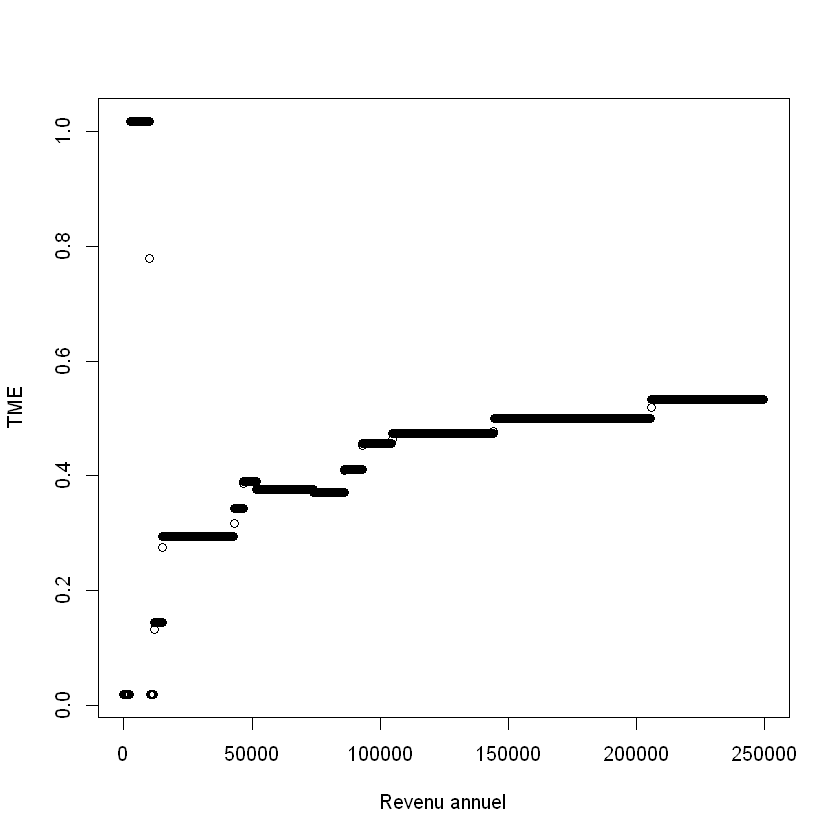

In [8]:
tme <- function(incr,imax){
  # calcule les taux marginaux effectifs d'imposition, par incréments de "incr"$, jusqu'à imax$
  incm <- seq(0,imax,by=incr) # vecteur des niveaux de revenus
  tax <- sapply(incm,function(x) itax(x)[1]) # applique la taxe sur chaque niveau de revenu
  tax2 <- c(tax[2:(length(tax))],0) # décale le taux de taxe
  deltatax <- tax2-tax # taxe marginale
  tm <- deltatax/incr # taux marginal effectif
  plot(incm[1:length(incm)-1],tm[1:length(incm)-1],xlab='Revenu annuel', ylab='TME')
  return(list(incm[1:length(incm)-1],tm[1:length(incm)-1]))
}
outtme <- tme(100,250000)

Il est maintenant temps de maximiser l'utilité de l'individu. On peut substituer la contrainte budgétaire et obtenir:

$$
U(L)=\alpha_i\ln(\bar{L}-L) + \ln(w_iL-t(w_iL)) + v_0(L=0) + v_f(L\in[1750,2000])
$$

En supposant (ce qui n'est pas le cas) que *L* est une variable continue et que $t(\cdot)$ est différentiable (et en laissant $v_0=v_f=0$), on peut prendre les conditions de premier ordre et réécrire:

$$
\frac{Loisir}{Consommation}=\frac{\alpha_i}{w_i(1-t'(w_iL))}
$$

On voit donc que le $\alpha_i$ permet à deux individus ayant le même salaire horaire $w_i$ d'avoir des taux marginaux de substitution Consommation/Loisir différents.

Ici, on suppose que l'individu a le choix d'ajuster ses heures de travail de façon discrète (des heures entières). Puisque ce sont des heures annuelles, ce n'est pas une hypothèse très forte. La fonction suivante évalue l'utilité pour différents choix d'heure de travail:

In [9]:
umarginal <- function(i,incr,alpha,theta){
  # calcule l'utilité pour i marginale par incréments de incr heures de travail
  lsup <- seq(0,Lmax,by=incr) # vecteur des heures travaillées
  util <- sapply(lsup,function(x) Utilite(i,x,alpha,theta)) # évalue l'utilité pour chaque niveau d'heures travaillées
  util2 <- c(util[2:(length(util))],0) # décale le vecteur des utilités
  deltautil <- util2-util # utilité marginale
  return(list(lsup[1:length(lsup)-1],deltautil[1:length(lsup)-1],util[1:length(lsup)-1]))
}

La fonction demande l'individu *i*, le plus petit ajustement des heures annuelles *incr* ainsi que le vecteur de préférences individuelles *alpha*. La fonction retourne une liste de trois éléments. Premièrement, *lsup*, le vecteur des heures travaillées auxquelles la fonction est évaluée. Deuxièmement, *deltautil* qui est l'utilité marginale entre $L$ et $L+1$ heures travaillées. Troisièmement, *util* qui est l'utilité évaluée à chaque valer de *lsup*. 

## Calibration

Avec la commande suivante, on trouve facilement le nombre d'heures travaillées pour *i=10*, pour le *alpha* déclaré au début du code, pouvant ajuster ses heures de travail par blocs de *lincr* heures annuellement.

In [10]:
theta0 <- rep(1,(k+3))*0.01 # valeur initial de theta: k+1=écart-type des erreurs, k+2=40h/sem, k+3=0h/sem
alpha <- as.numeric(Xmat%*%matrix(theta0[1:4],4,1)) # valeur initiale de alpha
vec_u <- umarginal(10,lincr,alpha,theta0)[[3]] # vecteur des utilités
Lstar <- (which(vec_u==max(vec_u))-1)*lincr # nombre d'heures qui maximise l'utilité.
print(c('Annuel:',Lstar, 'Hebdomadaire:',Lstar/weeks))

[1] "Annuel:"       "3750"          "Hebdomadaire:" "75"           


Ici, notre individu *i=10* travaille très peu! C'est esssentiellement en raison des valeurs de *theta* choisies, ce qui entraîne que *alpha* est relativement élevé, donc que l'individu accorde peu d'importance au Loisir.

Pour régler cette situation, nous allons utiliser les données sur les heures travaillées disponibles dans la *Labour Force Survey*.

La procédure décrite ici est celle de la Méthode des Moments Généralisés Simulés. Essentiellement, on n'observe pas l'hétérogénéité des préférences des individus (i.e. leur substitution Consommation/Loisir). Tel que décrit plus haut, on peut résumer cette information par $\alpha_i$. Ici, on va supposer une forme paramétrique:

$$\ln(\alpha_i)=\mathbf{x}_i\theta$$

et on va aussi suppose que l'utilité est aléatoire:
$$
\hat{U}_i(C,L)=U_i(C,L)+\varepsilon_{i,L},
$$
où $\varepsilon_{i,L}$ suit une loi normale de variance $\sigma^2$.

Essentiellement, ici, on va vouloir choisir les valeurs de $\theta$ afin que les heures travaillées produites par le modèle (i.e.celles issue de la maximisation de l'utilité des individus) soient conformes avec les données

Par exemple, on pout vouloir avoir le même nombre moyen (moyenne sur tous les individus) d'heures travaillées et le même écart-type de la distribution des heures travaillées. On appelle les caractéristiques que l'on veut reproduire des *moments*. Dans cet exemple, il y a donc 2 moments: les heures moyennes travaillées et l'écart-type des heures travaillées.

Par contre, notez qu'il y a plusieurs variables explicatives, donc il y a probablement plusieurs valeurs de $\theta$ qui permettent de répliquer la moyenne et l'écart-type des heures travaillées. On dit que le modèle est *sous-identifié*. Pour que le modèle soit identifié, il nous faut au minimums autant de moments que de paramètres à estimer. En multipliant le vecteur des heures travaillées par la matrice des caractéristiques individuelles, on obtient facilement des moments intuitifs.

Le code suivant génère les moments associés.

In [11]:
rhours <- as.numeric(lfsqc$ATOTHRS)*weeks # nombre d'heures annuelles sur une base de 'weeks' semaines de travail
wrhours <- rhours*wght
rwse <-  sqrt((sum(wght*(rhours^2))/sum(wght))-(sum(wrhours)/sum(wght))^2)
#rmoments <- c(colSums(matrix(rep(wrhours,k),n,k)*Xmat)/sum(wght),rwse,sum(as.numeric(rhours>=1750&rhours<=2000)*wght)/sum(wght),sum(as.numeric(rhours==0)*wght)/sum(wght)) # calcul des moments
rmoments <- c(colSums(matrix(rep(wrhours,k),n,k)*Xmat)/sum(wght),rwse,sum(as.numeric(rhours==2000)*wght)/sum(wght),sum(as.numeric(rhours==0)*wght)/sum(wght)) # calcul des moments
print(rmoments)

[1] 1.614918e+03 9.247550e+03 7.351689e+02 6.278814e+03 7.156712e+02
[6] 2.229233e-01 6.369477e-02


On a donc 7 moments ici:
- (1) moyenne(heures travaillées)
- (2) moyenne(heures travaillées $\times$ age)
- (3) moyenne(heures travaillées -- femme)
- (4) moyenne(heures travaillées $\times$ niveau d'éducation)
- (5) écart-type(heures travaillées)
- (6) moyenne(travaille entre 35 et 40h / semaine)
- (7) moyenne(ne travaille pas)

Notez ici que les moyennes et l'écart-type sont pondérés (les individus ne sont pas également représentatifs de la population)!

On veut donc choisir une valeur de $\theta$ telle que les moments simulés par le modèle soient proche des moments dans les données. Malgré que nous ayons autant de moments que de paramètres, nous ne pouvons en général pas être certains qu'il existe une unique valeur de $\theta$ qui fasse l'affaire. C'est pour cela que nous parlons habituellement de "calibration" et non d'"estimation" du modèle. Aussi, nous n'allons en général pas calculer les intervales de confiance sur les valeurs calibrées de $\theta$.

Par contre, en pratique, la calibration s'opère comme une estimation classique, i.e. nous allons minimiser la distance entre les moments simulés et les moments des données:
$$
GMM(\theta)=(\mathbb{E}Moments(\theta)-Moments)'(\mathbb{E}Moments(\theta)-Moments)
$$
où $\mathbb{E}Moments(\theta)$ est la moyenne des moments simulés pour différents tirages des $\varepsilon_i$ et $Moments$ sont les moments des données. La procédure est donc de minimiser $GMM(\theta)$. Voici le code R associé:

In [12]:
wrapi <- function(i,sim,alpha,theta){
    u <- as.numeric(umarginal(i,lincr,alpha,theta)[[3]])+as.numeric(erreur[[sim]][i,])*exp(theta[k+1]) # utilité pour chaque niveau d'heures travaillées
      # notez ici le changement de variable "exp(theta[6])" afin de s'assurer que l'écart-type soit toujours un chiffre positif.
    h <- (which(u==max(u))-1)*lincr # heures travaillées qui maximisent l'utilité
    return(min(h))
}
simhours <- function(theta){
  alpha <- exp(as.numeric(Xmat%*%matrix(theta[1:k],k,1))) # simulation des préférences alpha pour chaque individu
  moments <- rep(0,length(theta)) # vecteur de zéros qui va contenir la moyenne des moments simulés
  for (sim in 1:nsim){
     hours <- as.numeric(sapply(1:n,function(i) wrapi(i,sim,alpha,theta)))
     wh <- wght*hours
     swse <-  sqrt((sum(wght*(hours^2))/sum(wght))-(sum(wh)/sum(wght))^2)
     #moments <- moments + c(colSums(matrix(rep(wh,k),n,k)*Xmat)/sum(wght),swse,sum(as.numeric(hours>=1750&hours<=2000)*wght)/sum(wght),sum(as.numeric(hours==0)*wght)/sum(wght)) # calcul des moments     
    moments <- moments + c(colSums(matrix(rep(wh,k),n,k)*Xmat)/sum(wght),swse,sum(as.numeric(hours==2000)*wght)/sum(wght),sum(as.numeric(hours==0)*wght)/sum(wght)) # calcul des moments     
  }
  moments <- moments/nsim # fait la moyenne
  return(moments)
}

distrhours <- function(theta){
  moments <- simhours(theta) # moments simulés
#  gmm <- sum((moments/max(rmoments,rep(1,length(theta)))-rep(1,length(theta)))^2) # distance entre les moments simulés et les moments dans les données
   gmm <- sum((moments-rmoments)^2) # distance entre les moments simulés et les moments dans les données
  return(gmm)
}

In [13]:
summary(exp(as.numeric(Xmat%*%matrix(theta0[1:k],k,1))))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.020   1.094   1.116   1.116   1.139   1.197 

Rappelez vous qu'un choc aléatoire est ajouté à $\alpha_i$ pour tenir compte de l'hétérogénéité inobservée. Une bonne pratique est de simuler les erreurs d'abord afin qu'elles soient les mêmes pour chaque évaluation des différentes valeurs de $\theta$ et ainsi éviter les problèmes numérique pour un nombre faible de simulations.

In [26]:
####### Dernières variables globales #######
nsim <- 10
erreur <- vector("list", nsim)
erreur2 <- vector("list",nsim)
for (s in 1:nsim){
  erreur[[s]] <- matrix(rnorm(n*(Lmax/lincr)),n,(Lmax/lincr))
  erreur2[[s]] <- rnorm(n)
}

On peut donc maintenant lancer la calibration.

In [27]:
thetatry <- c(0.01239040, -0.01531411,  0.01137535,  0.01061802,  0.01987626,  0.01161269, 0.01602443)
thetatry[4] <- thetatry[4]+0.01
thetatry[k+2] <- thetatry[k+2]+1
thetatry[k+3] <- thetatry[k+3]+0.7
#out <- optim(thetatry, fn=distrhours) # minimise la fonction gmmfct prenant theta comme valeur de départ.
#thetatry <- out$par
#print(out)

On voit la valeur calibrée de theta dans $out\$ par$ et la valeur de la fonction objective dans $out\$ value$. On peut maintenant voir les moments simulés (moyenne sur *nsim* simulations) et les moments réels avec le code suivant:

In [28]:
print(thetatry)
print(simhours(thetatry))
print(rmoments)

[1]  0.01239040 -0.01531411  0.01137535  0.02061802  0.01987626  1.01161269
[7]  0.71602443
[1] 2.006617e+03 1.119527e+04 9.823911e+02 7.577383e+03 6.901733e+02
[6] 3.539441e-01 0.000000e+00
[1] 1.614918e+03 9.247550e+03 7.351689e+02 6.278814e+03 7.156712e+02
[6] 2.229233e-01 6.369477e-02


On voit donc que la majorité des moments sont bien simulés, sauf que le modèle produit trop de variation dans les heures travaillées: l'écart-type des heures travaillées est très grand. Regardons la distribution réelle des heures travaillées.

[1] 4000


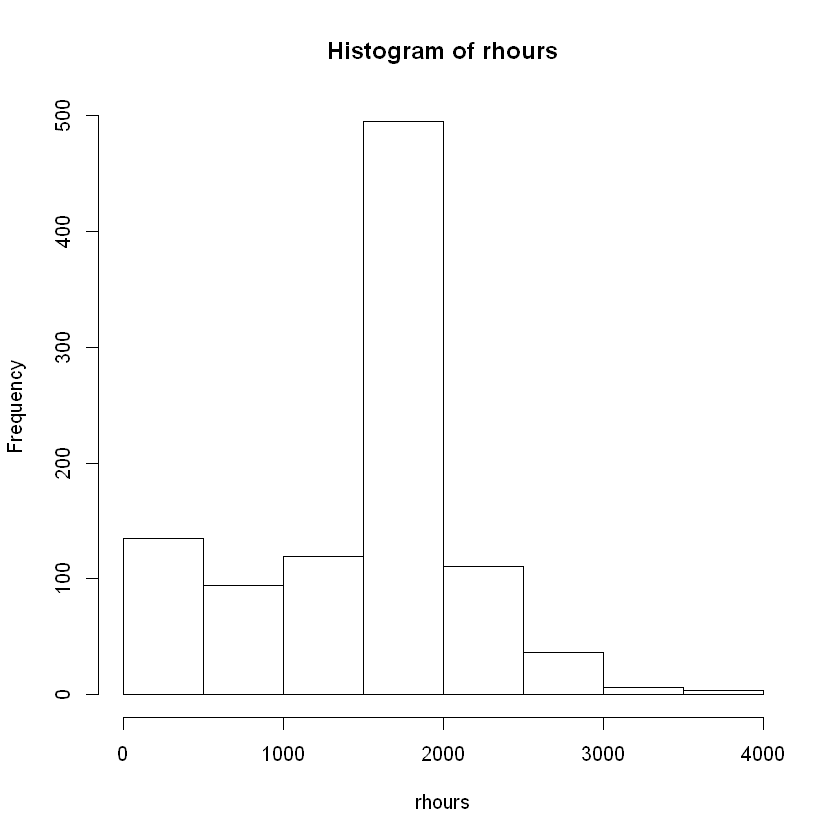

In [29]:
hist(rhours)
print(max(rhours))

On voit bien la masse importante juste avant 2000 heures de travail (i.e. 40 heures par semaine pendant 50 semaines), ce qui est intuitivement clair. Le code suivant nous donne un exemple de distribution des heures travaillées données par le modèle.

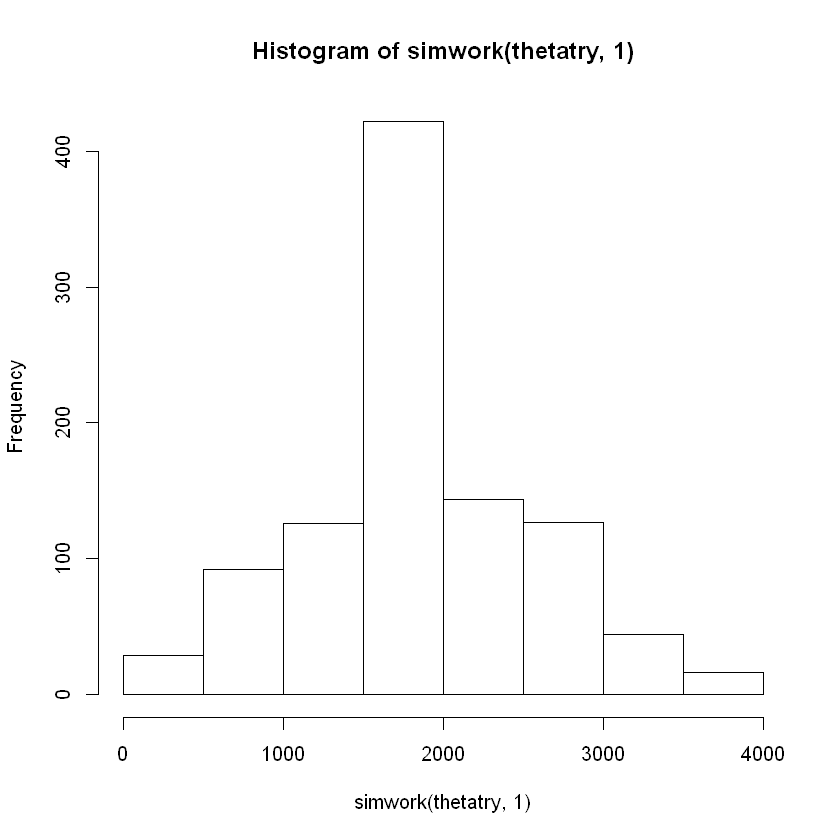

In [30]:
simwork <- function(theta,sim){
    hours <- rep(0,n) # vecteur de zéros qui va contenir les heures travaillées simulées
    alpha <- exp(as.numeric(Xmat%*%matrix(theta[1:k],k,1))) # simulation des préférences alpha pour chaque individu
    for (i in 1:n){
      u <- umarginal(i,lincr,alpha,theta)[[3]]+as.numeric(erreur[[sim]][i,])*exp(theta[k+1]) # utilité pour chaque niveau d'heures travaillées
      h <- (which(u==max(u))-1)*lincr # heures travaillées qui maximisent l'utilité
      hours[i] <- h # conserve dans le vecteur
    }
    return(hours)
}
hist(simwork(thetatry,1))

Notre modèle est donc loins d'être parfait. Il peut être amélioré en ajustant notre spécification des préférences, i.e. en changeant l'expression:

$$\ln(\alpha_i)=\mathbf{x}_i\theta,$$

ou plus généralement en supposant une autre forme de fonction d'utilité. Il y a de nombreuses possibilités... à vous de jouer !

Pour l'instant, la valeur estimée de $\theta$ nous donne une distribution des heures travaillées, ce qui nous permet de calculer les taxes, le bien-être et beaucoup d'autre variables.

In [31]:
makestats <- function(theta){
   stats_var <- matrix(0,n,4)
   for (sim in 1:nsim){
     h <- simwork(theta,sim)
     inc <- h*wage
     t <- sapply(inc,function(x) itax(x)[1])
     alpha <- exp(as.numeric(Xmat%*%matrix(theta[1:k],k,1)))
     u <- sapply(1:n, function(i) Utilite(i,h[i],alpha,theta))
     stats_var[,1] <- stats_var[,1] + (sort(h)/nsim)
     stats_var[,2] <- stats_var[,2] +(sort(u)/nsim)
     stats_var[,3] <- stats_var[,3] +(sort(inc)/nsim)
     stats_var[,4] <- stats_var[,4] +(sort(t)/nsim)
   }
   return(stats_var)
}
matstats <- makestats(thetatry)
colnames(matstats) <- c("heures travaillées","utilité","revenu brut","taxes et transferts")
summary(matstats)

 heures travaillées    utilité       revenu brut     taxes et transferts
 Min.   : 250       Min.   :16.04   Min.   :  4289   Min.   :    79.27  
 1st Qu.:1669       1st Qu.:17.98   1st Qu.: 30393   1st Qu.:  5197.30  
 Median :2000       Median :18.51   Median : 46374   Median : 10062.49  
 Mean   :2009       Mean   :18.55   Mean   : 54779   Mean   : 14271.96  
 3rd Qu.:2375       3rd Qu.:19.15   3rd Qu.: 70443   3rd Qu.: 19183.06  
 Max.   :3925       Max.   :20.66   Max.   :257920   Max.   :110493.75  

Cela nous donne donc des données intéressantes à comparer. Vous pouvez aussi naturellement vous intéresser à d'autres variables comme par exemple l'indice de Gini. Faites par contre attention d'utiliser correctement les poids échantillonaux lorsque vous travaillez avec des variables globales!

## Impact de réforme

On a donc une valeur de $\theta$ qui permet de répliquer les moments observés dans les données et de donner quelques statistiques descriptives de l'économie simulée. On peut donc maintenant commencer à faire des analyses de réformes. À titre d'exemple, ici, enlevons le programme d'aide sociale.

In [20]:
as <- 0

On observe donc la modification suivante aux TME:

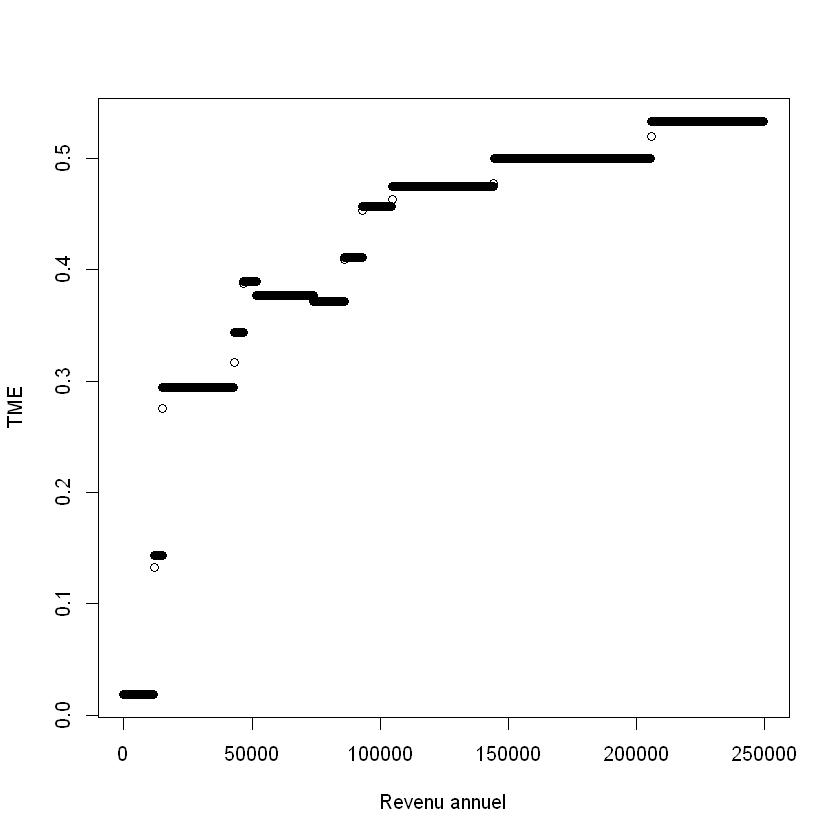

In [21]:
outtme <- tme(100,250000)

On peut donc utiliser le modèle pour voir les changements anticipés sur les valeurs des moments.

In [22]:
print(simhours(thetatry))

[1] 2.007261e+03 1.113652e+04 9.934861e+02 7.640257e+03 7.212621e+02
[6] 3.327551e-01 0.000000e+00


On peut aussi voir les autres statistiques prédites:

In [23]:
matstats_noas <- makestats(thetatry)
colnames(matstats_noas) <- c("heures travaillées","utilité","revenu brut","taxes et transferts")
summary(matstats_noas)

 heures travaillées    utilité       revenu brut     taxes et transferts
 Min.   : 250       Min.   :16.12   Min.   :  3375   Min.   :    62.37  
 1st Qu.:1500       1st Qu.:17.95   1st Qu.: 29453   1st Qu.:  4921.09  
 Median :2000       Median :18.48   Median : 46958   Median : 10275.01  
 Mean   :2023       Mean   :18.52   Mean   : 55236   Mean   : 14448.50  
 3rd Qu.:2500       3rd Qu.:19.12   3rd Qu.: 73605   3rd Qu.: 20374.24  
 Max.   :4000       Max.   :20.67   Max.   :238320   Max.   :100044.99  

En particulier, ici on voit que tous se sont mis à travailler. C'est une conséquence directe de l'hypothèse sur l'utilité: sans aide sociale, ne pas travailler implique une consommation nulle et une utilité de -Infini. Les individus sont donc prêts à tout pour arriver à consommer. Remettons l'histograme des heures travaillées (simulées) sur le modèle avec assurance emploi:

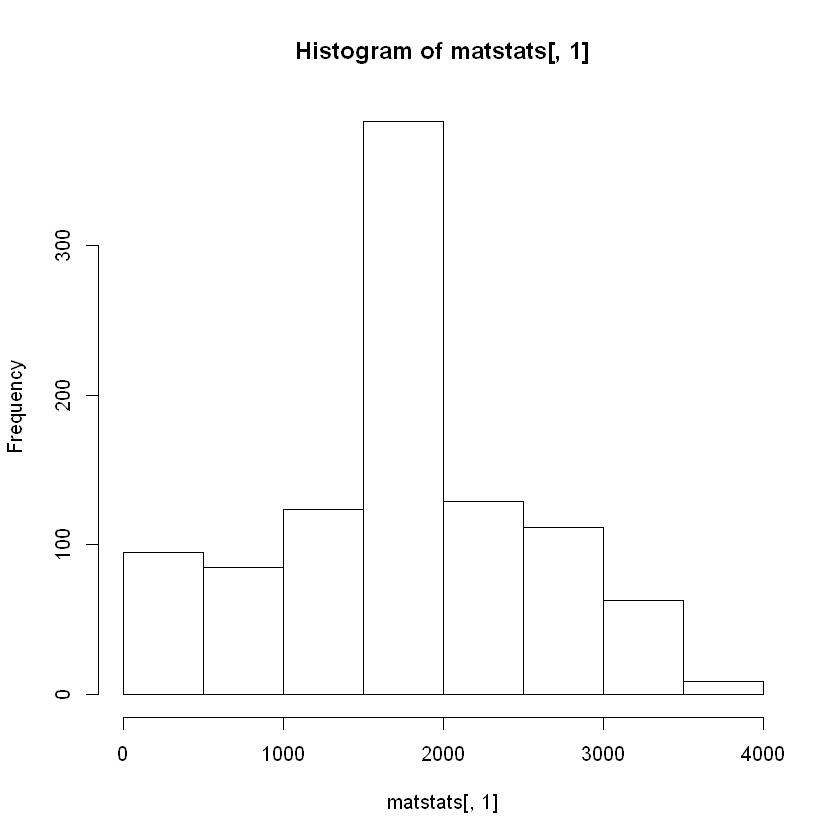

In [24]:
hist(matstats[,1])

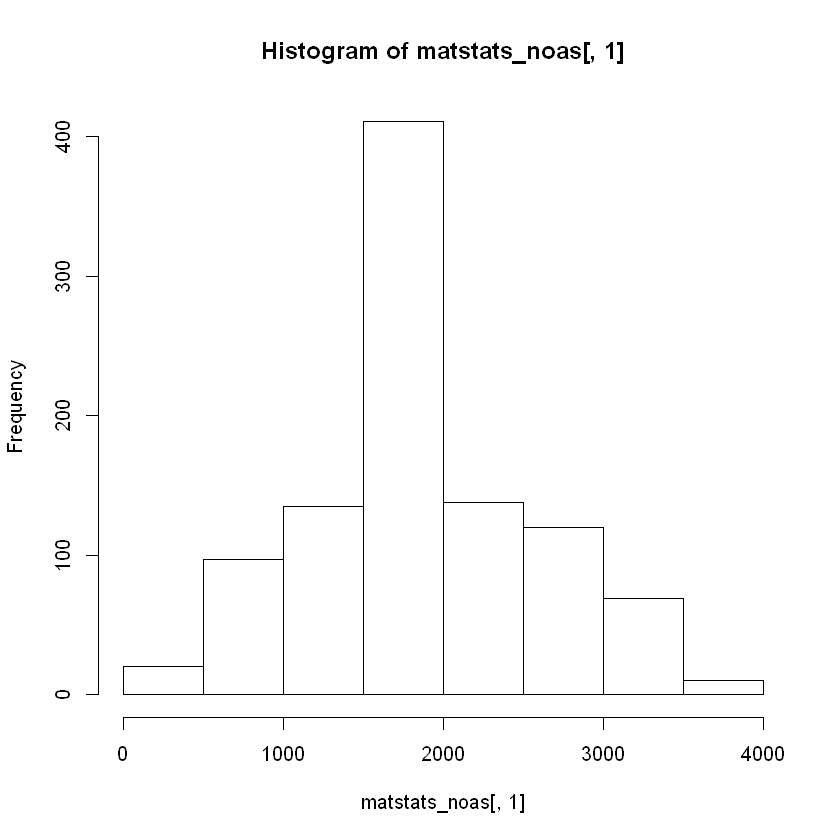

In [25]:
hist(matstats_noas[,1])